# Titanic Modeling
- Reference: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

## 1. Import libralies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load processed data

In [3]:
# Load data
train = pd.read_csv('../data/processed/train.csv', index_col=0)
test = pd.read_csv('../data/processed/test.csv', index_col=0)

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]
X_train = train.drop(labels=["Survived"], axis=1)

raw_test = pd.read_csv("../data/raw/test.csv")
IDtest = raw_test["PassengerId"]

In [4]:
raw_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 3. Simple Modeling

### 3.1 Cross validate models

In [5]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [6]:
# Modeling step Test differents algorithms
random_state = 43
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans": cv_means,
                        "CrossValerrors": cv_std,
                        "Algorithm": ["SVC",
                                        "DecisionTree",
                                        "AdaBoost",
                                        "RandomForest",
                                        "ExtraTrees",
                                        "GradientBoosting",
                                        "MultipleLayerPerceptron",
                                        "KNeighboors",
                                        "LogisticRegression",
                                        "LinearDiscriminantAnalysis"]})

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


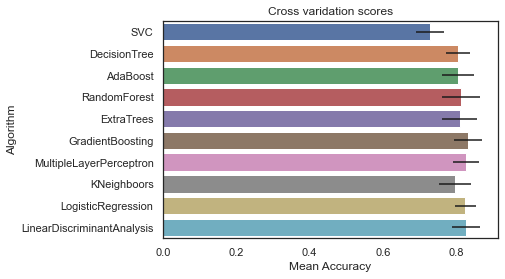

In [7]:
g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, orient="h", **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross varidation scores")

In [8]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.728439,0.037824,SVC
1,0.805905,0.033566,DecisionTree
2,0.804782,0.044035,AdaBoost
3,0.814869,0.051789,RandomForest
4,0.810400,0.047383,ExtraTrees
5,0.832784,0.038357,GradientBoosting
6,0.827179,0.036552,MultipleLayerPerceptron
7,0.798027,0.042947,KNeighboors
8,0.826055,0.029720,LogisticRegression
9,0.827179,0.037236,LinearDiscriminantAnalysis


### 3.2 Hyperparameter tunning for best models

In [9]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()

gb_param_grid = {"loss": ["deviance"],
                 "n_estimators": [100, 200, 300],
                 "learning_rate": [0.1, 0.05, 0.01],
                 "max_depth": [4, 8],
                 "min_samples_leaf": [100, 150],
                 "max_features": [0.3, 0.1]
                }

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best Score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8316729088639201

In [10]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators": [100, 300],
                 "criterion": ["gini"],
                }

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best Score
gsGBC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8316729088639201

### 3.3 Plot learning curves
- Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

[0.1   0.325 0.55  0.775 1.   ]
[ 80 260 440 620 801]
891
[0.04125    0.01365791 0.00861241 0.0060543  0.00487531]
[0.00375    0.03109925 0.03092737 0.03434896 0.03930187]
[0.1   0.325 0.55  0.775 1.   ]
[ 80 260 440 620 801]
891
[0.03061862 0.00832939 0.00799018 0.00703973 0.00723664]
[0.05803619 0.03371818 0.03196863 0.03579476 0.03513388]


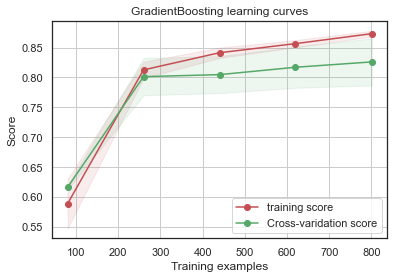

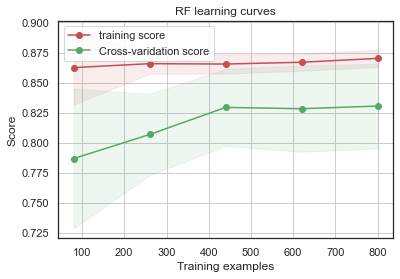

In [11]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve
    """
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    if ylim is not None:
        plt.ylim(*ylim)

    print(train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    print(train_sizes)
    print(len(X))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    print(train_scores_std)
    print(test_scores_std)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-varidation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(GBC_best, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(RFC_best, "RF learning curves", X_train, Y_train, cv=kfold)

### 3.4 Feature importance of tree based classifiers

IndexError: list index out of range

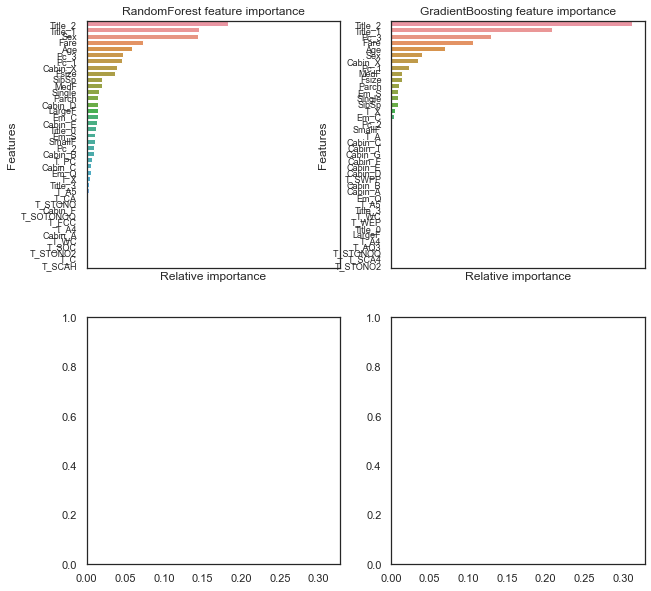

In [12]:
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex="all", figsize=(10, 10))

names_classifiers = [("RandomForest", RFC_best), ("GradientBoosting", GBC_best)]

nclassifier = 0
for row in range(n_rows):
    for col in range(n_cols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(x=classifier.feature_importances_[indices][:40], y=X_train.columns[indices][:40], orient="h", ax=axes[row][col])
        #g = sns.barplot(x=classifier.feature_importances_[indices][:40], y=X_train.columns[indices][:40], orient="h")
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

### 3.5 Ensemble modeling

In [13]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('gbc', GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, Y_train)

## 4. Prediction

In [14]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')

submission_data = pd.concat([IDtest, test_Survived], axis=1)

submission_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## 5. save submission data

In [15]:
submission_data.to_csv("../data/submission/20220110_ensemble_RF_GB.csv", index=False)